In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import train_test_split

from pprint import pprint
from time import time

import pandas as pd
import numpy as np
import logging
import warnings

# Display progress logs on stdout.
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

warnings.filterwarnings('ignore')

files = 'businesses_train', 'businesses_test'
df = (pd.concat([pd.read_csv(f'yelp_dataset/{f}.csv') for f in files])
        .drop(['business_id', 'categories'], axis=1))

df.head()

,$,$$,$$$,$$$$,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,OutdoorSeating,...,quiet,rating,romantic,street,touristy,trendy,upscale,valet,validated,very_loud
0,0,1,0,0,0,1,0,1,1,0,...,0,0.117806,NaN,True,NaN,NaN,NaN,False,False,0
1,0,1,0,0,0,1,1,1,0,1,...,0,0.028369,NaN,True,NaN,NaN,NaN,False,False,0
2,0,1,0,0,1,0,0,1,1,0,...,0,-0.041573,False,False,False,False,False,False,False,0
3,1,0,0,0,1,1,0,0,0,1,...,0,0.178532,NaN,False,NaN,NaN,NaN,False,False,0
4,0,1,0,0,0,1,0,1,0,0,...,0,-0.980185,NaN,False,NaN,NaN,NaN,False,False,0


In [6]:
# Scale ground truth to range [1, 10].
scaler = MinMaxScaler(feature_range=(1, 10))
_y = df.pop('rating')
y = scaler.fit_transform(_y[:, None])

# Impute missing values using "most_frequent" strategy.
imputer = Imputer(strategy='most_frequent')
_X = df.values
X = imputer.fit_transform(_X)

X, y

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]), array([[6.39323986],
        [6.24775628],
        [6.13398481],
        ...,
        [5.8952458 ],
        [5.44797965],
        [6.74382941]]))

<h1>GradientBoosting</h1>

In [ ]:
# TODO(@koustavmukherjee)

# ExtraTrees

<h3>ExtraTreesRegressor</h3>

In [16]:
# Split data into train and test portions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [122]:
# Employ Grid Search for ET classifier.
etr = ExtraTreesRegressor(n_estimators=100, random_state=0)

parameters = dict(
    max_depth=(3, 4, 5), 
    min_samples_split=(0.1, 0.2), 
    min_samples_leaf=(0.05, 0.1)
)
grid_search = GridSearchCV(etr, parameters, cv=5, error_score=0.0,
                           n_jobs=-1, verbose=1)

print("Parameters:")
pprint(parameters)

t0 = time()
grid_search.fit(X, y)

print("Done in %0.3fs" % (time() - t0))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Parameters:
{'max_depth': (3, 4, 5),
 'min_samples_leaf': (0.05, 0.1),
 'min_samples_split': (0.1, 0.2)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.4min finished


Done in 524.723s
Best score: 0.050
Best parameters set:
	max_depth: 4
	min_samples_leaf: 0.05
	min_samples_split: 0.1


In [125]:
from sklearn.ensemble import ExtraTreesRegressor

# Train ExtraTreesRegressor model.
print('Training ExtraTreesRegressor Model.')
etr = ExtraTreesRegressor(n_estimators=100, max_depth=4, min_samples_split=0.1, 
    min_samples_leaf=0.05, random_state=0, n_jobs=-1)
etr.fit(X_train, y_train.ravel())

# Compute RMSE of trained model.
preds = etr.predict(X_test)
threshold = 0.75 # Define threshold. This can be changed depending on the accuracy desired.
print('Regressor RMSE:', mean_squared_error(preds, y_test) ** .5)
print('Regressor Accuracy:', (np.abs(preds - y_test.ravel()) <= threshold).mean())

Training ExtraTreesRegressor Model.
Regressor RMSE: 0.9023523718630528
Regressor Accuracy: 0.6116744991343062


<h3> ExtraTreesClassifier </h3>

Train a classifier by rounding the ratings (ground truth) to the nearest integer. The ground truth is divided into 5 classes {1, 2, 3, 4, 5}, which are then used to train the classifier. 

[[3.]
 [2.]
 [3.]
 ...
 [3.]
 [3.]
 [3.]] [1. 2. 3. 4. 5.]
3.0    61922
4.0    12012
2.0    10716
1.0      219
5.0       32
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


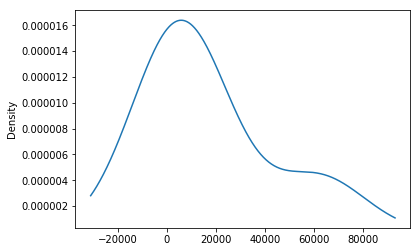

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

# Reduce num_classes to 5 for classification task. 
y_train_scaled = (y_train / 2).round()
y_train_scaled[y_train_scaled == 0] = 1

y_test_scaled = (y_test / 2).round()
y_test_scaled[y_test_scaled == 0] = 1

ser = pd.Series(y_train_scaled.ravel()).value_counts()
print(y_train_scaled, np.unique(y_train_scaled))
print(ser)

print(ser.plot.density())

<h1> XGBoost </h1>

MacOSX installation: https://machinelearningmastery.com/install-xgboost-python-macos/ <br/>
Windows installation: https://stackoverflow.com/a/39811079/4909087

<h3> XGBoostRegressor </h3>

In [7]:
import xgboost as xgb
print('XGBoost Version:', xgb.__version__)

# Split data into train and test portions.

# Run the classifier on non-imputed data.
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    _X, y, test_size=0.25, random_state=42)

XGBoost Version: 0.80


In [30]:
clf = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.25,
                max_depth=10, reg_alpha=10, n_estimators=100, n_jobs=-1)

clf.fit(X_train2, y_train2)

preds = clf.predict(X_test2)
print(preds)

threshold = 0.75 # Define threshold. This can be changed depending on the accuracy desired.
print('Regressor RMSE:', mean_squared_error(preds, y_test2) ** .5)
print('Regressor Accuracy:', (np.abs(preds - y_test2.ravel()) <= threshold).mean())

[5.94766   5.9868665 6.09038   ... 5.541321  6.3664412 6.2896605]
Regressor RMSE: 0.8696905189124551
Regressor Accuracy: 0.6422034557082789


In [23]:
# Pass data to XGBoost a little differently 
#    - Frequency Encode PriceRange
#    - Preserve Boolean-ness of boolean columns

df_ = df.copy()
imputer = Imputer(strategy='most_frequent')
df_[:] = imputer.fit_transform(df_)

# Try frequency encoding the price range:
pricing = df.filter(like='$')

ser = pricing.columns[np.argmax(pricing.values, axis=1)].to_series()
ser = ser.map(ser.value_counts(normalize=True))

print(ser.head())

bool_cols = ['BikeParking', 'BusinessAcceptsCreditCards', 'Caters', 'GoodForKids', 
             'HasTV', 'OutdoorSeating', 'RestaurantsDelivery', 'RestaurantsGoodForGroups',
             'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 
             'WheelchairAccessible']

df_ = (df_.drop(pricing.columns.tolist(), axis=1)
          .assign(PriceRange2=ser.values)
          .sort_index(axis=1))

df_[bool_cols] = df_[bool_cols].astype(bool)

df_.head()

$$    0.539346
$$    0.539346
$$    0.539346
$     0.350241
$$    0.539346
dtype: float64


,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,OutdoorSeating,PriceRange2,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,...,paid,quiet,romantic,street,touristy,trendy,upscale,valet,validated,very_loud
0,False,True,False,True,True,False,0.539346,False,True,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,True,True,True,False,True,0.539346,False,True,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,False,False,True,True,False,0.539346,False,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,True,False,False,False,True,0.350241,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,True,False,True,False,False,0.539346,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
params = dict(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.25,
                max_depth=4, reg_alpha=10, n_estimators=150, n_jobs=-1, silent=True)

data_dmatrix = xgb.DMatrix(data=df_, label=y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=0)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.279872,0.000676,4.279834,0.004154
1,3.265612,0.000401,3.265573,0.004238
2,2.521274,0.000228,2.521291,0.004130
3,1.982425,0.000584,1.982550,0.003684
4,1.601075,0.000720,1.601190,0.003606


In [25]:
cv_results["test-rmse-mean"].tail(1) # Best RMSE

49    0.877771
Name: test-rmse-mean, dtype: float64

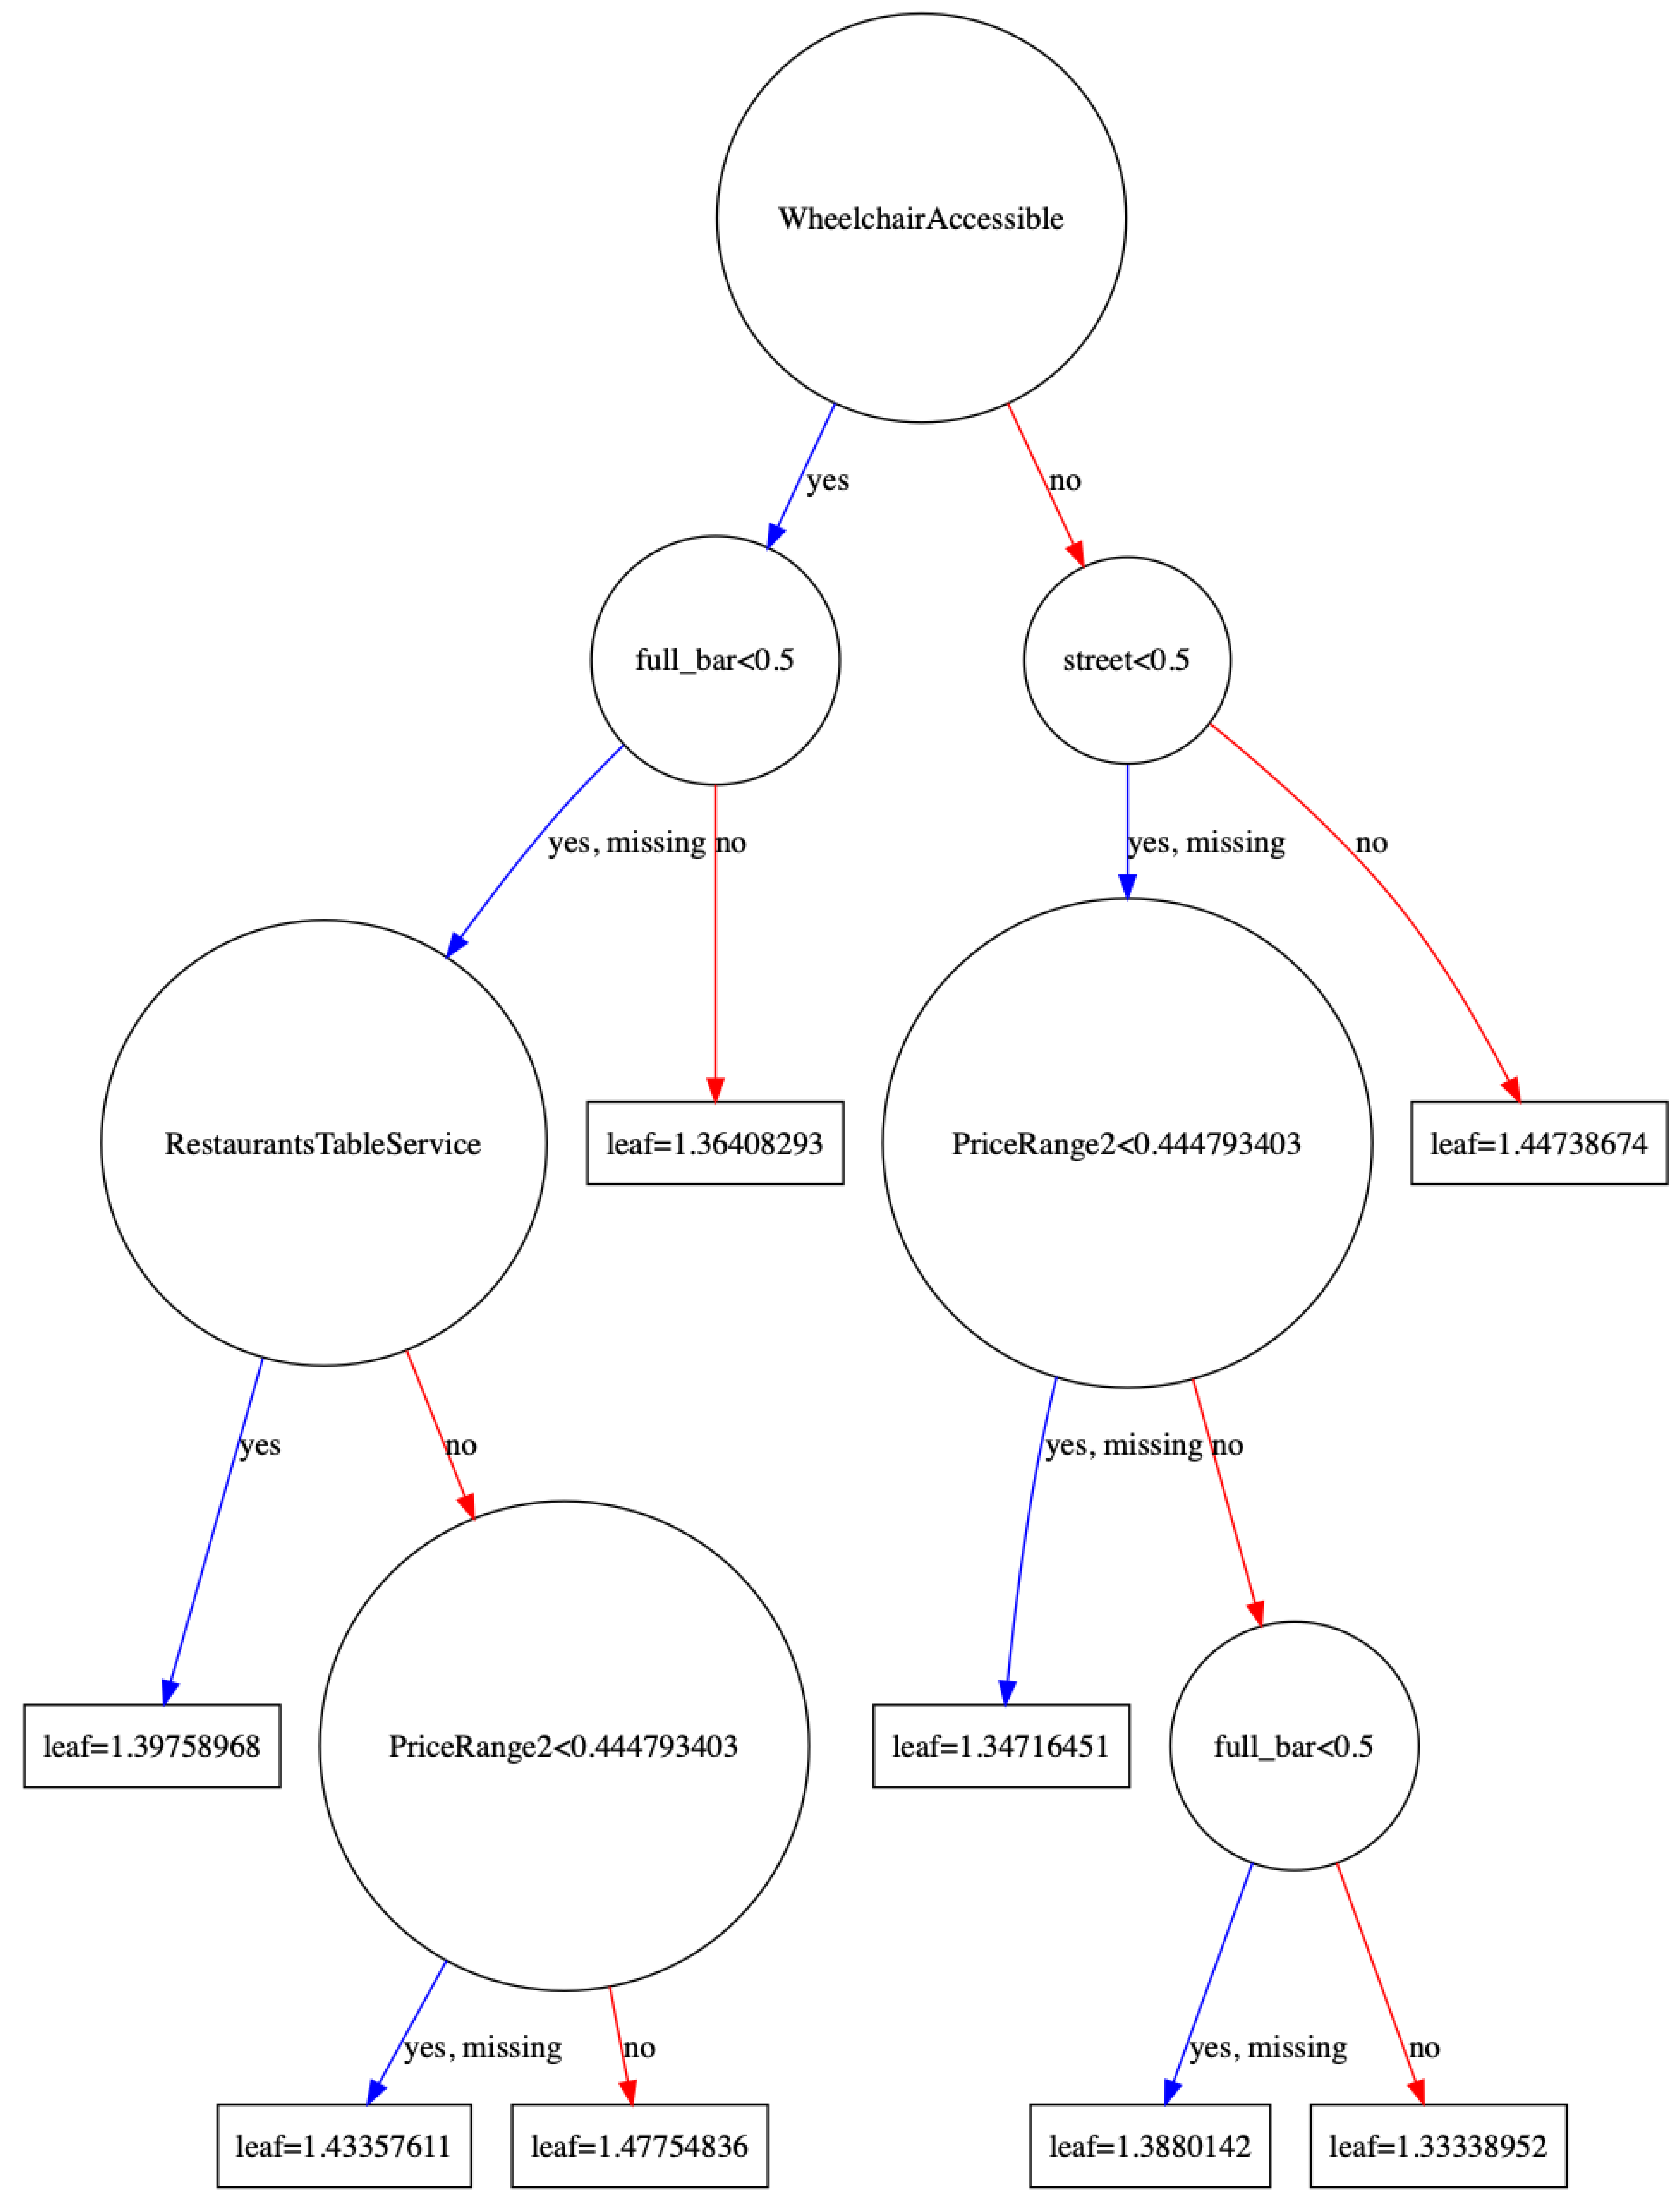

In [119]:
# Plotting XGBoost model Trees.
import matplotlib.pyplot as plt

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_tree(xg_reg,num_trees=0)
plt.axis('scaled')
plt.show()

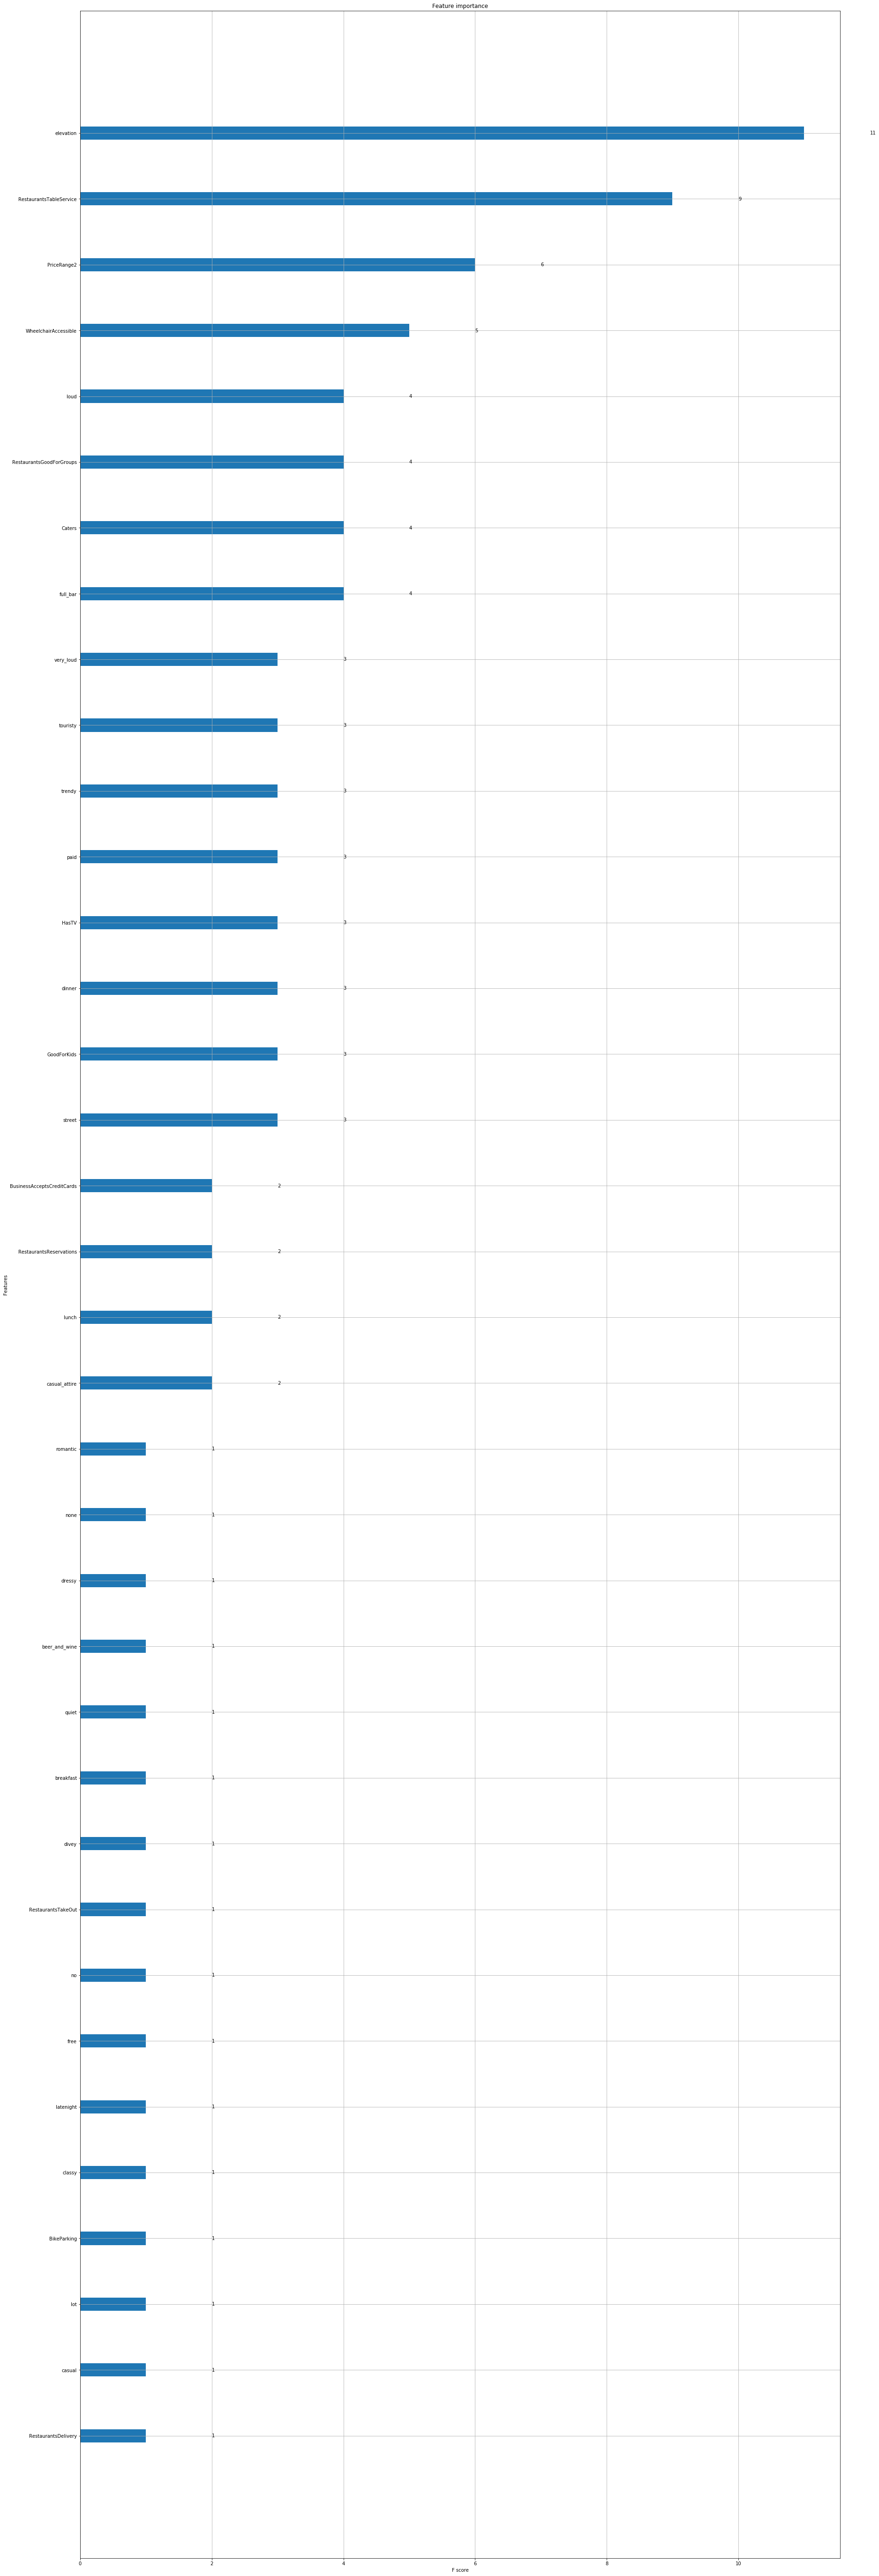

In [121]:
xgb.plot_importance(xg_reg)
plt.axis('scaled')
plt.show()

<h3> XGBoostRegressor + PCA </h3>

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
# Remove elevation - examine how results change.
data_pca = pca.fit_transform(
            MinMaxScaler((0, 100)).fit_transform(df_.drop('elevation', axis=1))) 

data_pca

array([[ 8.21084639e+01, -6.99168879e+01,  7.38417613e+01,
        -9.83363955e+00,  8.52336778e+00],
       [ 9.65823665e+01, -2.78963824e+01, -8.40114652e+01,
         3.80391992e+01, -3.24652361e+01],
       [ 9.61291738e+01, -1.42483982e+01,  9.04889331e+01,
        -5.44314529e+01, -2.50292047e-02],
       ...,
       [-1.07304122e+02, -4.24045174e+01,  2.61033239e+01,
         6.96836340e+00, -1.58647804e+01],
       [-1.21673735e+02, -3.21535416e+01,  3.19435096e+01,
         1.90980943e+01, -4.12553823e+00],
       [-6.62674818e+01,  7.29914421e+01, -7.73688969e+01,
         2.95561841e+01, -1.23059931e+01]])

In [39]:
data_dmatrix = xgb.DMatrix(data=data_pca, label=y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=0)

cv_results["test-rmse-mean"].tail(1) # Best RMSE

49    0.897181
Name: test-rmse-mean, dtype: float64

<h3> XGBoostClassifier </h3>

In [18]:
print("Training XGBoostClassifier.")
clf = xgb.XGBClassifier(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1,
                max_depth=3, reg_alpha=10, n_estimators=10, n_jobs=-1)

y_train2_scaled = (y_train2 / 2).round()
y_train2_scaled[y_train2_scaled == 0] = 1

y_test2_scaled = (y_test2 / 2).round()
y_test2_scaled[y_test2_scaled == 0] = 1

print(y_train2_scaled)
print(pd.Series(y_train2_scaled.squeeze()).value_counts())

clf.fit(X_train2, y_train2_scaled)

# Compute model accuracy
preds = clf.predict(X_test2)
print('Classifier Accuracy:', accuracy_score(preds, y_test2_scaled))

Training XGBoostClassifier.
[[3.]
 [2.]
 [3.]
 ...
 [3.]
 [3.]
 [3.]]
3.0    61922
4.0    12012
2.0    10716
1.0      219
5.0       32
dtype: int64
Classifier Accuracy: 0.7292675170488675
